In [1]:
%matplotlib notebook

In [1]:
from importlib import reload
from two_transmons import Rabi
reload(Rabi)
from scipy.optimize import *
from two_transmons.Rabi import *
import two_transmons.DoubleTransmonSystem
from two_transmons.DoubleTransmonSystem import *
import two_transmons.VacuumRabiSimulation
from two_transmons.VacuumRabiSimulation import *
import single_transmon.Transmon
from single_transmon.Transmon import *
from ReadoutResonator import *
from qutip import *
from tqdm.notebook import tqdm
from two_transmons.ZPulse import *
from importlib import reload
import two_transmons.ParallelCalculations
from two_transmons.ParallelCalculations import *
from two_transmons.CalcTime import *
from two_transmons.Tomography import *
from scipy.linalg import cholesky
from p_tqdm import p_map, p_imap
import time

from itertools import product

In [73]:
transmon_states = range(3)

In [74]:
transmon_trunc=[]
for a in transmon_states:
    for b in transmon_states:
        #for c in transmon_states:
         #   for d in transmon_states:
                transmon_trunc.append([a,b])

In [75]:
idx = 0
low_energy_states = []
low_energy_state_indices = []
for idx, state_combination in enumerate(transmon_trunc):
    state_combination = array(state_combination)
    
    if sum(state_combination) <= 2: 
        print (state_combination)
        low_energy_states.append(state_combination)
        low_energy_state_indices.append(idx)
           
low_energy_states_mask = np.zeros([idx+1]*2, dtype=bool)
for idx1 in low_energy_state_indices:
    for idx2 in low_energy_state_indices:
        low_energy_states_mask[idx1, idx2] = True
        
print("Total %d kets included" % len(low_energy_states))


[0 0]
[0 1]
[0 2]
[1 0]
[1 1]
[2 0]
Total 6 kets included


/tmp/ipykernel_1406275/2195240206.py:5: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  state_combination = array(state_combination)
/tmp/ipykernel_1406275/2195240206.py:7: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  if sum(state_combination) <= 2:


In [76]:
low_energy_state_indices

[0, 1, 2, 3, 4, 6]

In [86]:
H_test = H_class[2][0]

In [87]:
H_test

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  1.38518736 0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         1.38518736 0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         1.38518736]
 [0.         0.         0.         1.38518736 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         1.38518736 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.38518736
  0.         0.         0.        ]]

In [88]:
Qobj(H_test.data[low_energy_states_mask].reshape((len(low_energy_state_indices),-1)))

Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         1.38518736]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.38518736 0.         0.        ]]

In [40]:
Nc = 7
N_trunc = 3
Ec1 = 0.25 * 2 * np.pi
Ec2 = 1.03*Ec1
Ecc = 0.01/1.2**2 * 2 * np.pi # 1.2 is my estimate for n_{ge} matrix element
Ej1 = Ec1 * 100
Ej2 = Ec2 * 100
d = 0.2

T1_1, T2_1 = 10e6, 5e6
T1_2, T2_2 = 5e6, 1e6

tr1 = Transmon(Ec1, Ej1, d, 1/T1_1, 1/T2_1, Nc, N_trunc, 1)
tr2 = Transmon(Ec2, Ej2, d, 1/T1_2, 1/T2_2, Nc, N_trunc, 2)
dts = DoubleTransmonSystem(tr1, tr2, Ecc)
dts.e_ops = [dts.two_qubit_operator(qubit1_operator = tr1.sx()),dts.two_qubit_operator(qubit1_operator = tr1.sy()),\
        dts.two_qubit_operator(qubit1_operator = tr1.sz()), dts.two_qubit_operator(qubit2_operator = tr2.sx()),\
        dts.two_qubit_operator(qubit2_operator = tr2.sy()),dts.two_qubit_operator(qubit2_operator = tr2.sz())]

r = ReadoutResonator(6, 1118, 1964, phi=0.29)
r.set_qubit_parameters(.05, 0.05, 5, 5.3, .2, .2)


freq_lim = 0.2
farg=cook_farg(20,freq_lim)
params=farg[0]['params']
Ts = linspace(0, params["finish"], params['t_points'])
T = Tomography(dts, Ts, params, r)

#print(params)

/tmp/ipykernel_1406275/2421593658.py:27: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  Ts = linspace(0, params["finish"], params['t_points'])
/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [41]:
create(N_trunc) * destroy(N_trunc)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 2.]]

In [42]:
create(N_trunc) * destroy(N_trunc) * (create(N_trunc) * destroy(N_trunc) - 1)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 2.]]

## Double transmon system spectrum

/tmp/ipykernel_1403792/1203245156.py:1: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  phi1s = linspace(0.45,0.5,500)
/tmp/ipykernel_1403792/1203245156.py:2: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  phi2s = ones_like(phi1s)*1/2


Energy levels calculation:   0%|          | 0/500 [00:00<?, ?it/s]

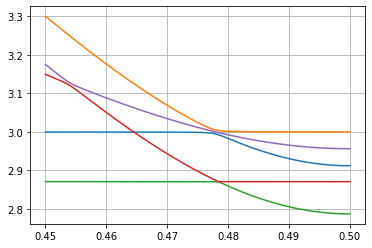

In [5]:
phi1s = linspace(0.45,0.5,500)
phi2s = ones_like(phi1s)*1/2
figure()
dts.plot_spectrum(phi1s, phi2s, exact_H = False)

In [7]:
#figure()
phi1s = linspace (0.0, 0.55, 400)
phi2s = ones_like(phi1s)*1/2
freq10=[]
freq01=[]
freq11=[]
freq02=[]
freq20=[]

for ind in tqdm(range(len(phi1s))):
    phi1 = phi1s[ind]
    phi2 = phi2s[ind]
    freq10.append((dts.e_state(phi1,phi2,1,True)[1] - dts.gg_state(phi1,phi2,True)[1])/2/pi)
    freq01.append((dts.e_state(phi1,phi2,2,True)[1] - dts.gg_state(phi1,phi2,True)[1])/2/pi)
    freq11.append((dts.ee_state(phi1,phi2,True)[1] - dts.gg_state(phi1,phi2,True)[1])/2/2/pi)
    freq20.append((dts.f_state(phi1,phi2,1,True)[1] - dts.gg_state(phi1,phi2,True)[1])/2/2/pi)
    freq02.append((dts.f_state(phi1,phi2,2,True)[1] - dts.gg_state(phi1,phi2,True)[1])/2/2/pi)


<ipython-input-7-0eb1f2728534>:2: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  phi1s = linspace (0.0, 0.55, 400)
<ipython-input-7-0eb1f2728534>:3: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  phi2s = ones_like(phi1s)*1/2
  0%|                                                                                          | 0/400 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:28<00:00, 14.14it/s]


## System spectrum


In [8]:
phi1s = linspace (0.40, 0.55, 400)
phi2s = ones_like(phi1s)*1/2
nu01, nu02 = [], []
nu10 = []
for  ind, phi in enumerate (phi1s):
    H1 = tr1.H_diag_trunc_approx(phi)
    H2 = tr2.H_diag_trunc_approx(phi2s[ind])
    evals,evecs = H1.eigenstates()
    evals2,evecs2 = H2.eigenstates()
    nu01.append((evals[1]-evals[0])/2/pi)
    nu02.append((evals[2]-evals[0])/2/pi/2)
    nu10.append((evals2[1]-evals2[0])/2/pi)
    

    


<ipython-input-8-eda3035025f2>:1: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  phi1s = linspace (0.40, 0.55, 400)
<ipython-input-8-eda3035025f2>:2: DeprecationWarning: scipy.ones_like is deprecated and will be removed in SciPy 2.0.0, use numpy.ones_like instead
  phi2s = ones_like(phi1s)*1/2


<IPython.core.display.Javascript object>


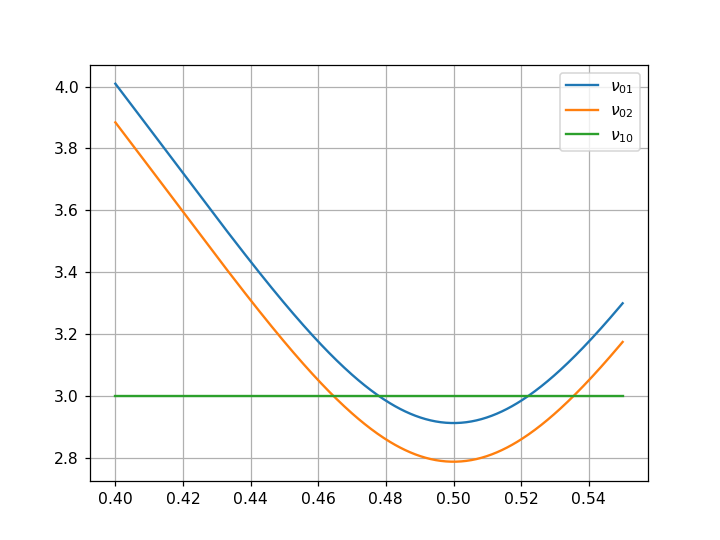

In [9]:
figure()
plot (phi1s, nu01, label = '$\\nu_{01}$' )
plot (phi1s, nu02, label = '$\\nu_{02}$' )
plot (phi1s, nu10, label = '$\\nu_{10}$' )
legend()
grid()    

## Form of the pulse

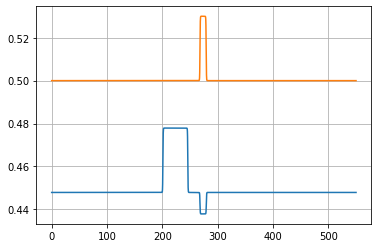

In [44]:
signal = ZPulse(Ts,params)
waveform1 = signal.waveform_iswap_zgate(1, t_start = 200 , t_finish = 247, t_zgate = 13.46)
#waveform1 = ones_like(Ts)*params['phi_base_level']
waveform2 = signal.waveform_iswap_zgate(2, t_start = 200, t_finish = 247, t_zgate = 13.2)
figure()
plot (Ts, waveform1)
plot (Ts, waveform2)

grid()

/home/alexeitolstobrov/Examples/transmon-simulations/two_transmons/ZPulse.py:53: RuntimeWarning: invalid value encountered in true_divide
  normalized = raw/max(raw)


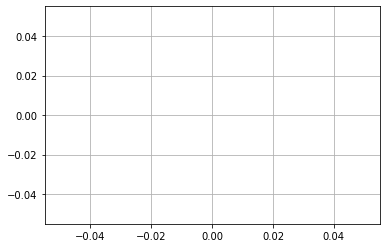

In [45]:
wf1, wf2 = T.build_waveforms_2iswap()
figure()
plot (Ts, wf1)
plot (Ts, wf2)

grid()


## Time evolution

In [46]:
T._2q_rotations[2]

((0, 0), (83.625, 0))

In [47]:
rho0 = Qobj(ket2dm(basis(9,0)), dims = [[3,3],[3,3]])

In [48]:
H_class = dts.H_iswap_RF_RWA_td(waveform1, waveform2, params, rotations = T._2q_rotations[2])

/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [52]:
H_class[1][0]

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]

In [11]:
ops = [dts.two_qubit_operator(qubit1_operator = tr1.sx()),dts.two_qubit_operator(qubit1_operator = tr1.sy()),\
    dts.two_qubit_operator(qubit1_operator = tr1.sz()), dts.two_qubit_operator(qubit2_operator = tr2.sx()),\
    dts.two_qubit_operator(qubit2_operator = tr2.sy()),dts.two_qubit_operator(qubit2_operator = tr2.sz())]

In [12]:
result = mesolve(H_class , rho0, Ts, c_ops = [],e_ops = dts.e_ops,progress_bar=True,
                 options=Options(nsteps = 200000, max_step =1e-3, store_states = True))

10.0%. Run time:   2.22s. Est. time left: 00:00:00:19
20.0%. Run time:   4.46s. Est. time left: 00:00:00:17
30.0%. Run time:   6.78s. Est. time left: 00:00:00:15
40.0%. Run time:   9.14s. Est. time left: 00:00:00:13
50.0%. Run time:  11.40s. Est. time left: 00:00:00:11
60.0%. Run time:  13.67s. Est. time left: 00:00:00:09
70.0%. Run time:  15.92s. Est. time left: 00:00:00:06
80.0%. Run time:  18.23s. Est. time left: 00:00:00:04
90.0%. Run time:  20.49s. Est. time left: 00:00:00:02
Total run time:  22.73s


In [22]:
#rho_final = Tomography.rho3dim_to_rho(result.states[-1])

In [23]:
rho_final, rho_ideal = T.find_iswap_rotation_matrix(2)
state_fidelity = Tomography.state_fidelity(rho_final, rho_ideal)
print(state_fidelity)

(0.9915008766515137-1.3096054724341685e-08j)


<IPython.core.display.Javascript object>


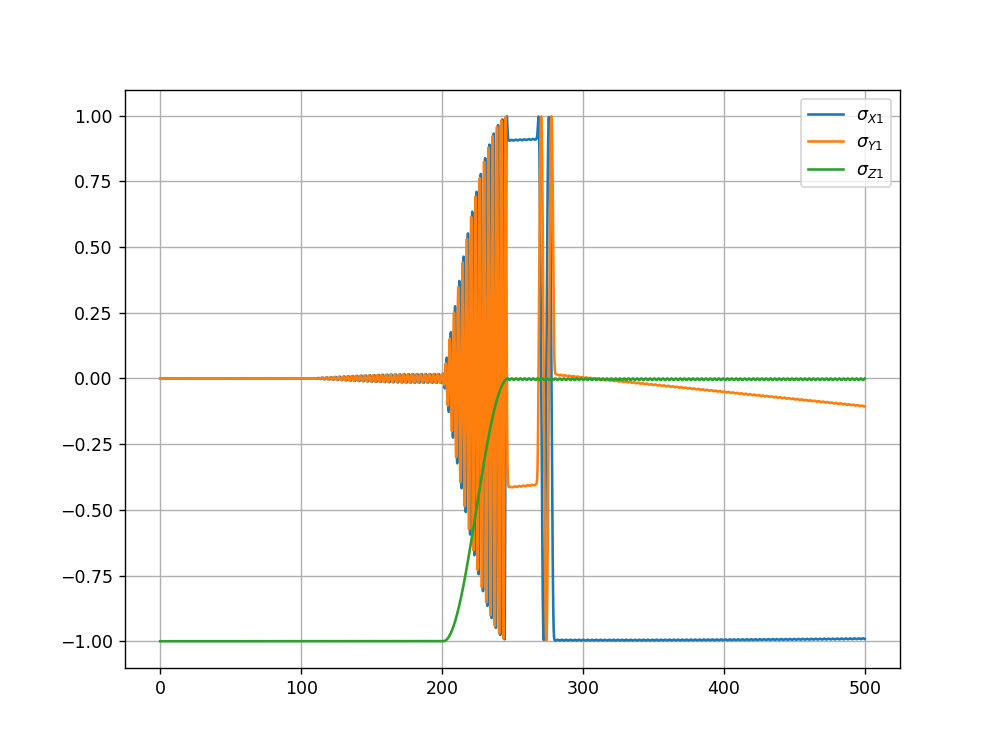

In [24]:
figure()
plot (Ts, result.expect[0], label = '$\sigma_{X1}$')
plot (Ts, result.expect[1], label = '$\sigma_{Y1}$')
plot (Ts, result.expect[2], label = '$\sigma_{Z1}$')
grid()
legend()

<IPython.core.display.Javascript object>


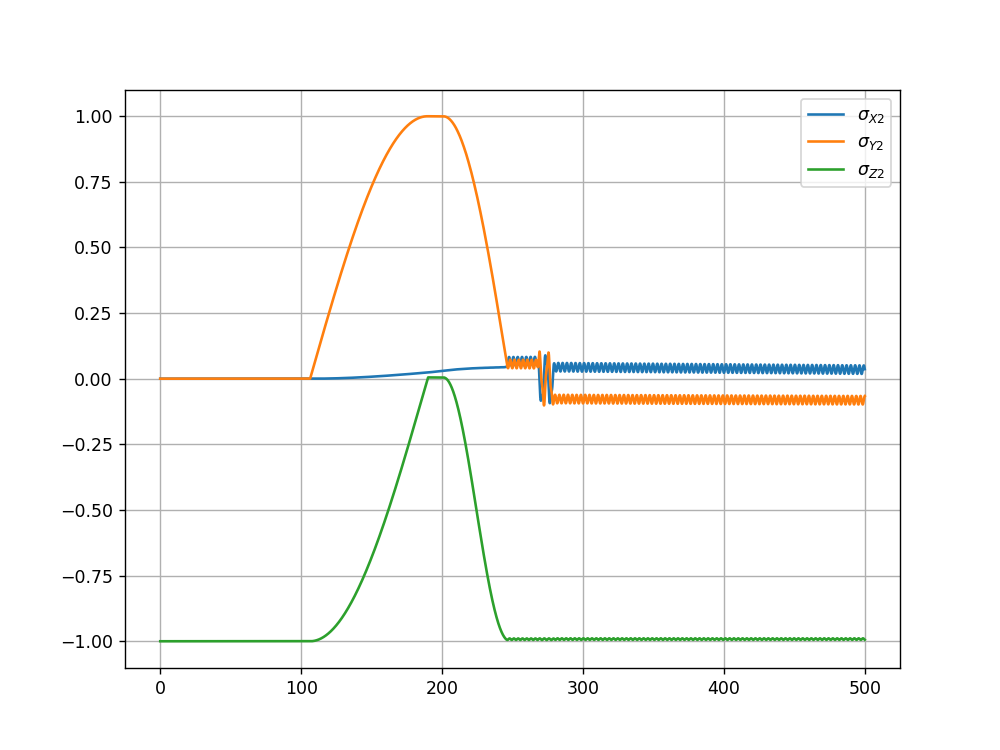

In [25]:
figure()
plot (Ts, result.expect[3],label = '$\sigma_{X2}$')
plot (Ts, result.expect[4], label = '$\sigma_{Y2}$')
plot (Ts, result.expect[5], label = '$\sigma_{Z2}$')
grid()
legend()

<IPython.core.display.Javascript object>


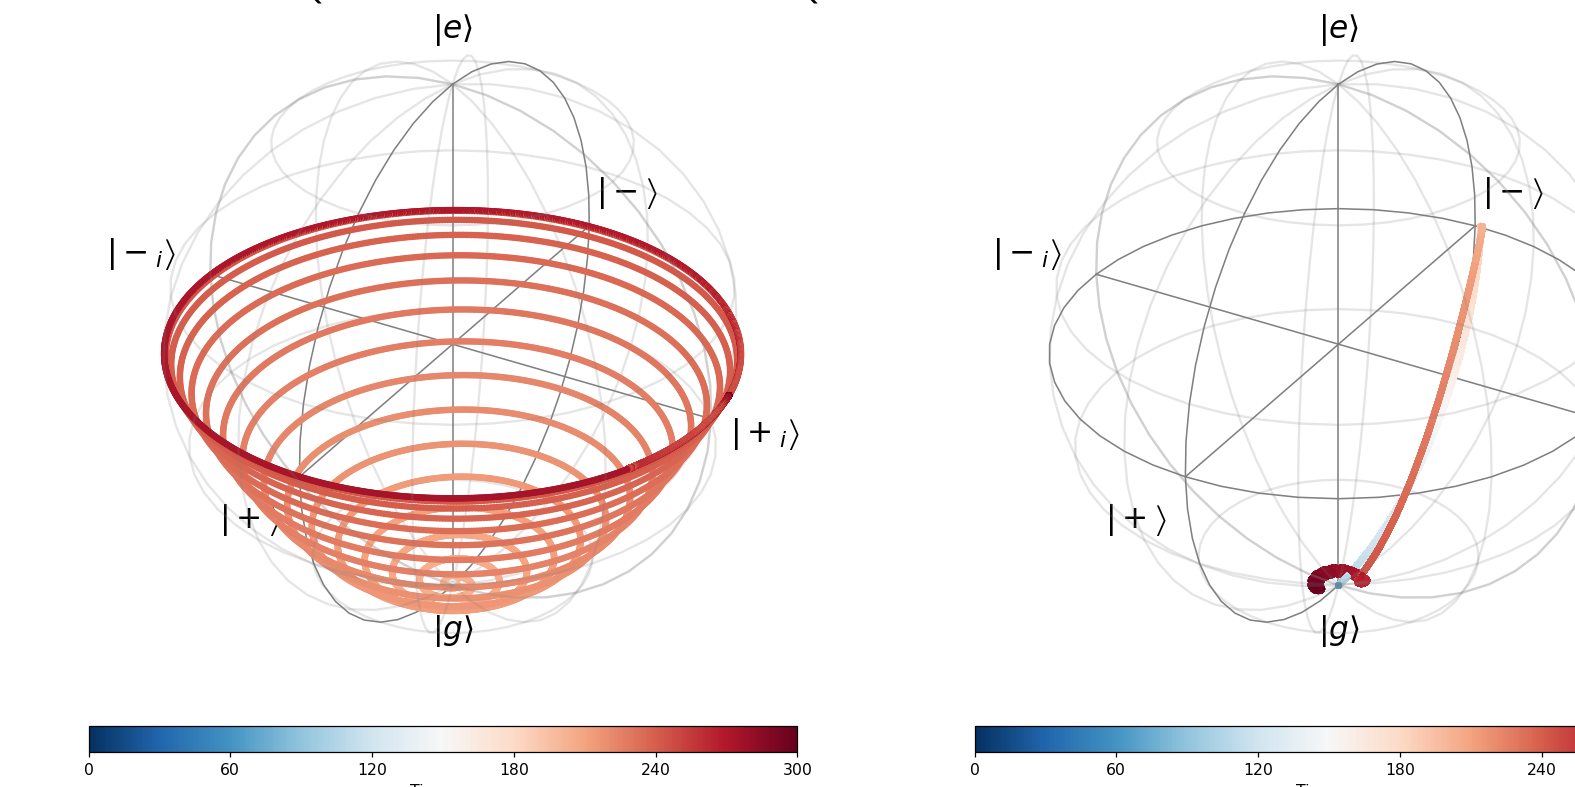

<IPython.core.display.Javascript object>


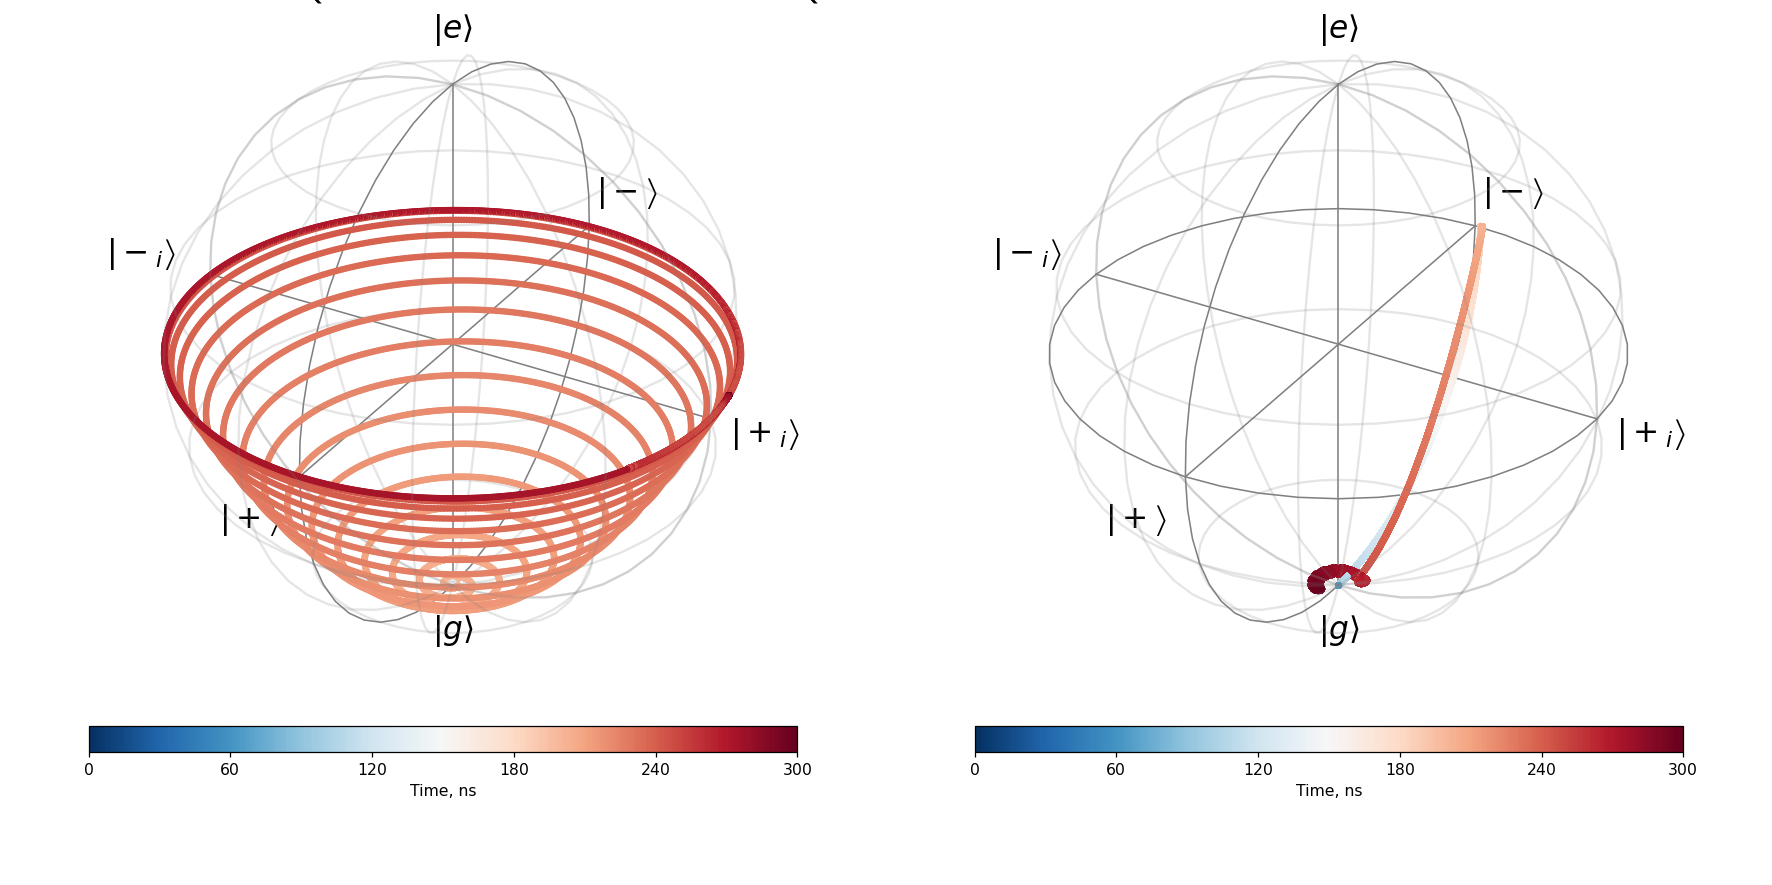

In [21]:
T.plot_qubits_dynamic(10,dm=result.states, interaction = True)

## Gate calibration

## $|0\rangle\ |-\rangle\ \rightarrow|-i\rangle\ |0\rangle$

In [22]:
signal = ZPulse(Ts,params)
rho0 = Qobj(ket2dm(basis(9,0)), dims = [[3,3],[3,3]])
waveform1 = signal.waveform_iswap_zgate(1, t_start = 200 , t_finish = 247, t_zgate = 31)
#waveform1 = ones_like(Ts)*params['phi_base_level']
waveform2 = signal.waveform_iswap_zgate(2, t_start = 200, t_finish = 247, t_zgate = 31)
H_class = dts.H_iswap_RF_RWA_td(waveform1, waveform2, params, rotations =  ((0, 0),(33.45*5/2,pi/2)))
result = mesolve(H_class , rho0, Ts, c_ops = [],e_ops = dts.e_ops,progress_bar=True,
                 options=Options(nsteps = 200000, max_step =1e-3, store_states = True))



C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


10.0%. Run time:   1.14s. Est. time left: 00:00:00:10
20.0%. Run time:   2.13s. Est. time left: 00:00:00:08
30.0%. Run time:   3.14s. Est. time left: 00:00:00:07
40.0%. Run time:   4.10s. Est. time left: 00:00:00:06
50.0%. Run time:   5.21s. Est. time left: 00:00:00:05
60.0%. Run time:   6.20s. Est. time left: 00:00:00:04
70.0%. Run time:   7.37s. Est. time left: 00:00:00:03
80.0%. Run time:   8.52s. Est. time left: 00:00:00:02
90.0%. Run time:   9.73s. Est. time left: 00:00:00:01
Total run time:  11.00s


In [24]:
T.fidelity_function_zgate(10,10,params['start'],4)

(0.46804277466110544-4.313255840098586e-09j)